This notebook showcases the downsampling scheme I developed in Summer 2017, to make a DESI-like sample. This is done by first abundance matchhing to the GAMA Luminosity function from [Loveday 2015](https://arxiv.org/abs/1505.01003), then downsampling to match what we expect from DESI by matching a catalog made by Song. 

There are a few python packages I use in this notebook that will need to be installed before running. 
* [Yao's code](https://bitbucket.org/yymao/abundancematching) to do the abundance matching. 
* Loading particles from disk requires one of Yao's other packages, [helpers](https://bitbucket.org/yymao/helpers/src). 
* Also, I used [Halotools](https://halotools.readthedocs.io/en/latest/), specifically the halo catalog loading and caching functionalities. 

In [1]:
%reset
from glob import glob
from os import path
import numpy as np
from halotools.sim_manager import CachedHaloCatalog, RockstarHlistReader, UserSuppliedPtclCatalog
from helpers.readGadgetSnapshot import readGadgetSnapshot
from AbundanceMatching import *
import h5py
import pandas as pd

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


/Users/eniaxhakaj/miniconda2/envs/astro3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from matplotlib import pyplot as plt
%matplotlib notebook

# Cache in the catalog

This should read in the big hlist catalog and cut it down to the mass cut & columns we give it. The parameters we will need are the following: 

- filename 
- columns to keep -- the vertical cut  
- cache filename -- where we're going to save the cached cut catalog 
- simulation name 
- halo finder
- redshift 
- version name 
- lbox and particle mass. -- for particle mass Sean has a formula that calculates it **(make sure this work in our case too!)**


In [3]:
# define all the parameters you need to cache in the catalog 
# REMOVE THE CUT FROM THIS CATALOG 

fname = "/home/exhakaj/Github/splashback3D/UM_SDMPL/hlist_0.84140_orig.list"

HLIST_COLS = {'halo_id': (1, 'i8'), 'halo_upid': (6, 'i8'),
              'halo_x': (17, 'f4'), 'halo_y': (18, 'f4'), 'halo_z': (19, 'f4'),
              'halo_vx': (20, 'f4'), 'halo_vy': (21, 'f4'), 'halo_vz': (22, 'f4'),
              'halo_mvir': (10, 'f4'), 
              'halo_snapnum': (31, 'i8'),'halo_vpeak':(60, 'f8'), 'halo_halfmass_scale': (61, 'f4'),
              'halo_Acc_Rate_1*Tdyn':(64, "f8"), "halo_Mpeak":(58, "f8")}


columns_to_keep = HLIST_COLS
cache_fname = "/Users/eniaxhakaj/data/hlist_0.84140_cache_fullmass.hdf5"
columns_to_convert = []
simname = "smdpl"
halo_finder = "rockstar"
a = 0.84140 # hardcoded from the file name 
redshift = (1. - a)/a
vname = "1." 
Lbox = 1000 
npart = 99994092 # counted how many lines were on the particle file (?)
particle_mass = 1.51e9

In [4]:
halocat = CachedHaloCatalog(fname=cache_fname, update_cached_fname=True)

False


In [5]:
halocat.halo_table.colnames

['halo_id',
 'halo_upid',
 'halo_x',
 'halo_y',
 'halo_z',
 'halo_vx',
 'halo_vy',
 'halo_vz',
 'halo_mvir',
 'halo_snapnum',
 'halo_vpeak',
 'halo_halfmass_scale',
 'halo_Acc_Rate_1*Tdyn',
 'halo_Mpeak',
 'halo_hostid',
 'halo_mvir_host_halo']

# Cache in and downsample the particles

The downsampling is done in two steps 

(1) Take a subset with replacement from the rows in your table. 

(2) Decrease the size of the sample by 1000 times 

(3) Use the indecces from part 1 and 2 to get the downsampled particles 

# Pair the particle and halo cats 

**What does this exactly do?**

# The luminosity function 

## Done with working code here .... 

Loading up a luminosity function. This one is from GAMA Survey, Loveday 2015. Note the selected redshift ranges. 

In [6]:
lf = np.genfromtxt('lf_r_sersic_z_0.2_0.3.dat', skip_header=True)[:,1:3]
#lf = np.genfromtxt('lf_r_sersic_z_0.1_0.2.dat', skip_header=True)[:,1:3]

In [7]:
lf

array([[-2.388e+01,  3.930e-07],
       [-2.338e+01,  1.870e-06],
       [-2.312e+01,  7.220e-06],
       [-2.288e+01,  1.870e-05],
       [-2.262e+01,  4.100e-05],
       [-2.238e+01,  1.090e-04],
       [-2.212e+01,  2.160e-04],
       [-2.188e+01,  3.880e-04],
       [-2.162e+01,  7.280e-04],
       [-2.138e+01,  1.170e-03],
       [-2.112e+01,  1.800e-03],
       [-2.088e+01,  2.520e-03],
       [-2.062e+01,  3.330e-03],
       [-2.038e+01,  4.200e-03],
       [-2.012e+01,  4.870e-03],
       [-1.988e+01,  6.020e-03],
       [-1.962e+01,  6.580e-03],
       [-1.938e+01,  5.650e-03],
       [-1.912e+01,  1.030e-03],
       [-1.888e+01,  7.840e-05],
       [-1.862e+01,  4.930e-04],
       [-1.838e+01,  2.240e-04],
       [-1.812e+01,  1.750e-04],
       [-1.788e+01,  1.270e-05]])

In [8]:
# apologies for the magic numbers. I tinkered with this particular LF for a while, since the edges get a little 
# noisy. This seemed to give the best extrapolation, but feel free to change. 
use_up_to = -6 
af = AbundanceFunction(lf[:use_up_to,0], lf[:use_up_to,1], (-27, -18),faint_end_fit_points = 7 )

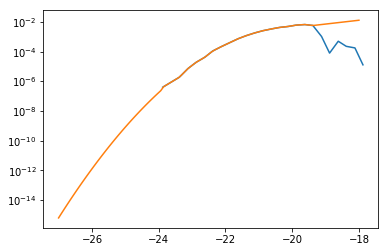

In [9]:
plt.figure()
plt.semilogy(lf[:,0], lf[:,1])
x = np.linspace(-27, -18, 101)
plt.semilogy(x, af(x))

In [10]:
print( max(af(x)))

0.012803895807302974


These checks are reccomended by Yao in his code, linked above.

In [11]:
scatter = 0.2
remainder = af.deconvolute(scatter*LF_SCATTER_MULT, 20)

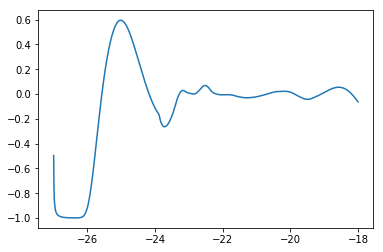

In [12]:
x, nd = af.get_number_density_table()
plt.figure()
plt.plot(x, remainder/nd);

In [13]:
max(nd)

0.020700864155704282

In [14]:
# calculate the number density of our halo proxy
halos = np.array(halocat.halo_table)
    
nd_halos = calc_number_densities(halos['halo_vpeak'], halocat.Lbox[0])

In [15]:
# Do the AB match here. 
full_catalog = af.match(nd_halos, scatter*LF_SCATTER_MULT)

In [16]:
mag_cut = -18 # choose a magitude cut, and make this cut on our sample
valid_idxs = np.logical_and(~np.isnan(full_catalog), full_catalog <= mag_cut)
catalog = full_catalog[valid_idxs]

/Users/eniaxhakaj/miniconda2/envs/astro3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less_equal
  


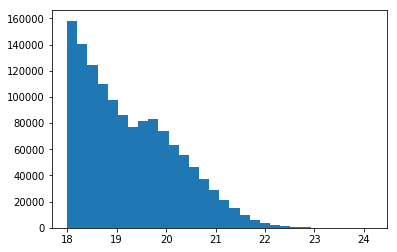

In [17]:
plt.figure()
plt.hist(-1*catalog, bins = 30);

In [18]:
np.savetxt('/Users/eniaxhakaj/Github/desiDeltaSigma/sham_catalog.npy', catalog) #activate if you want to save the uncut catalog 

We want this plot to approximately match this one from Song. 

In [19]:
song_cat = np.genfromtxt('gama_z0.1_0.3_rband_absmag.ascii')

In [20]:
mags = song_cat[song_cat[:,-1] > -10000,-1 ]

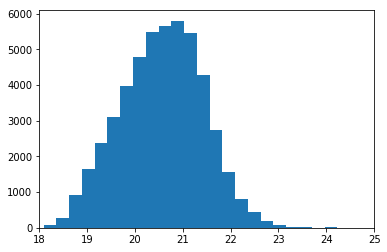

In [21]:
# plt.hist(-1*catalog, bins = 30);
plt.figure()
plt.hist(-1*mags, bins = 30);
plt.xlim([18,25]);

In [22]:
#downsample here
hist, bin_edges = np.histogram(-1*mags, bins = 30)
max_mag= bin_edges[np.argmax(hist)+1]
downsample_idxs = set()
makeshift_hist = []
length = len(hist)

#Index of the bin we want to match to. 
match_idx = -16
low, high = bin_edges[match_idx:match_idx+2]

in_bin_idxs = np.where(np.logical_and(low <= -1*catalog, -1*catalog <= high))[0]

ratio = float(len(in_bin_idxs))/hist[match_idx] #the ratio by which to downsample to. 

#This will print the relative sizes of the bin selected, and its edges. 
print (len(in_bin_idxs), hist[match_idx])
print (low, high)
print (ratio)
#work backwords in bins, from brightest to dimmest and randomly downsample. 
for real_idx, count in enumerate(reversed(hist)):
    idx = length-real_idx-1
    low, high = bin_edges[idx:idx+2]
    
    in_bin_idxs = np.where(np.logical_and(low <= -1*catalog, -1*catalog <= high))[0]

    # if our SHAM has more galaxies then we wanted to downsample to, just leave them all in. 
    # This should only happen in really bright bins
    if in_bin_idxs.shape[0] <= np.ceil(ratio*count):
        sampled_idxs = in_bin_idxs
    else:
        # else, downsample to the correct ratio
        sampled_idxs = np.random.choice(in_bin_idxs, size = int(np.ceil(ratio*count)), replace = False)

    downsample_idxs = downsample_idxs | set(sampled_idxs) #add the downsample idxs to our list
    
downsampled_catalog = catalog[np.array(list(downsample_idxs), dtype=int)]

2834 1559
22.09452019885058 22.36143571093554
1.81783194355356


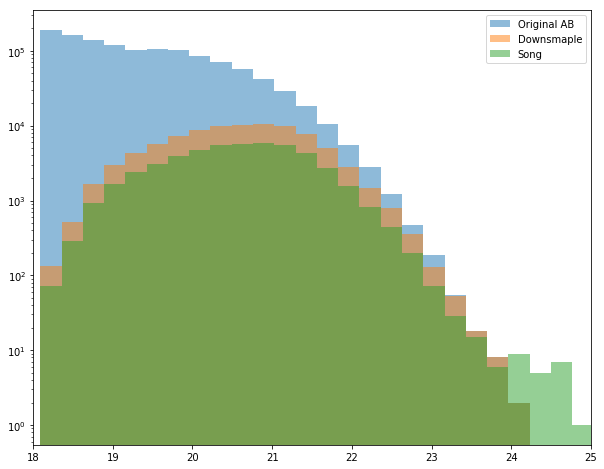

In [23]:
plt.figure(figsize = (10,8))
plt.hist(-1*catalog, bins = bin_edges, label = 'Original AB', alpha = 0.5)
plt.hist(-1*downsampled_catalog, bins = bin_edges, alpha = 0.5, label = "Downsmaple")
plt.hist(-1*mags, bins = bin_edges, alpha = 0.5, label = 'Song');
plt.xlim([18,25]);
plt.legend(loc='best')
plt.yscale('log')
plt.savefig("/Users/eniaxhakaj/Desktop/downsampling.png")

Yay! It worked. 

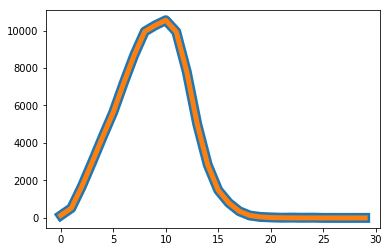

In [24]:
plt.figure()
plt.plot(hist*ratio, lw = 10)
plt.plot(np.histogram(-1*downsampled_catalog, bins = bin_edges)[0], lw = 5)

Yeah! let's save the indexs. 

In [25]:
#put the indicies into an array the size of our original catalog
downsampled_idxs_array = np.zeros_like(valid_idxs, dtype=bool)
counter = 0
for idx, val in enumerate(valid_idxs):
    if val:
        if counter in downsample_idxs:
            downsampled_idxs_array[idx] = True
        counter+=1


downsampled_idxs_array= np.where(valid_idxs)[0][np.array(list(downsample_idxs))]

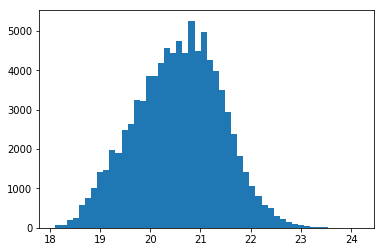

In [26]:
plt.figure()
plt.hist(-1*full_catalog[downsampled_idxs_array], bins = 50);

In [27]:
# save them! 
np.savetxt('gama_matched_catalog.npy', full_catalog)
np.savetxt('gama_matched_catalog_idxs.npy', downsampled_idxs_array)

In [28]:
full_catalog[downsampled_idxs_array]

array([-19.14383579, -22.15013933, -19.77859622, ..., -21.23938515,
       -20.2727349 , -21.04930591])

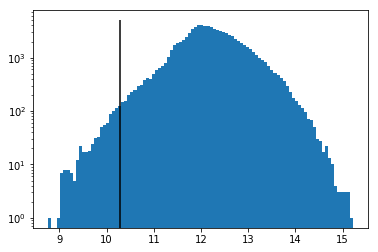

In [29]:
plt.figure()
plt.hist(np.log10(halocat.halo_table[downsampled_idxs_array]['halo_mvir']), bins = 100);
plt.vlines(np.log10(200*halocat.particle_mass), 0, 5e3)
plt.yscale('log')

## Make the plots that Alexie asked you 

<IPython.core.display.Javascript object>


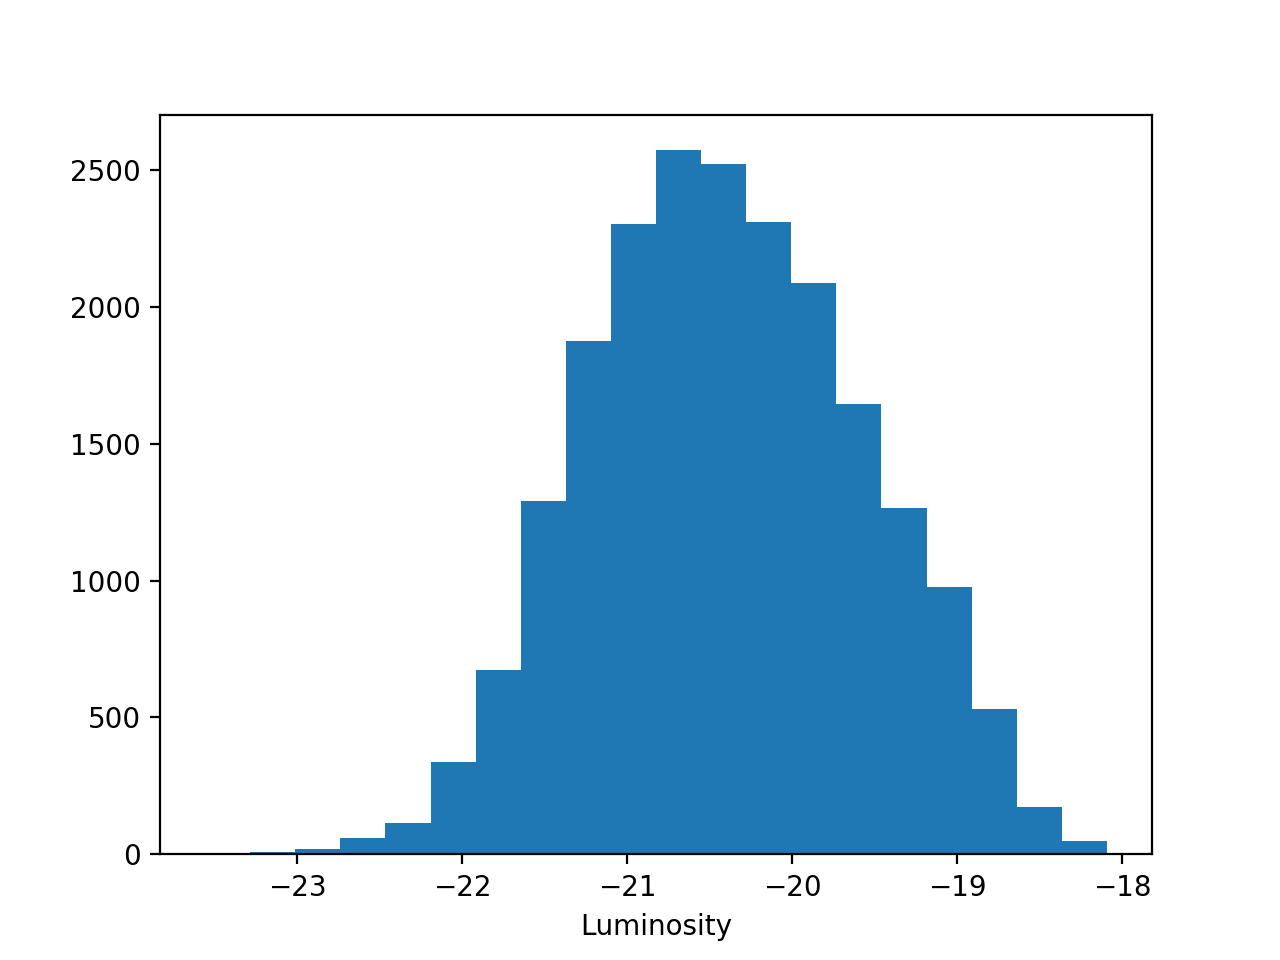

<IPython.core.display.Javascript object>


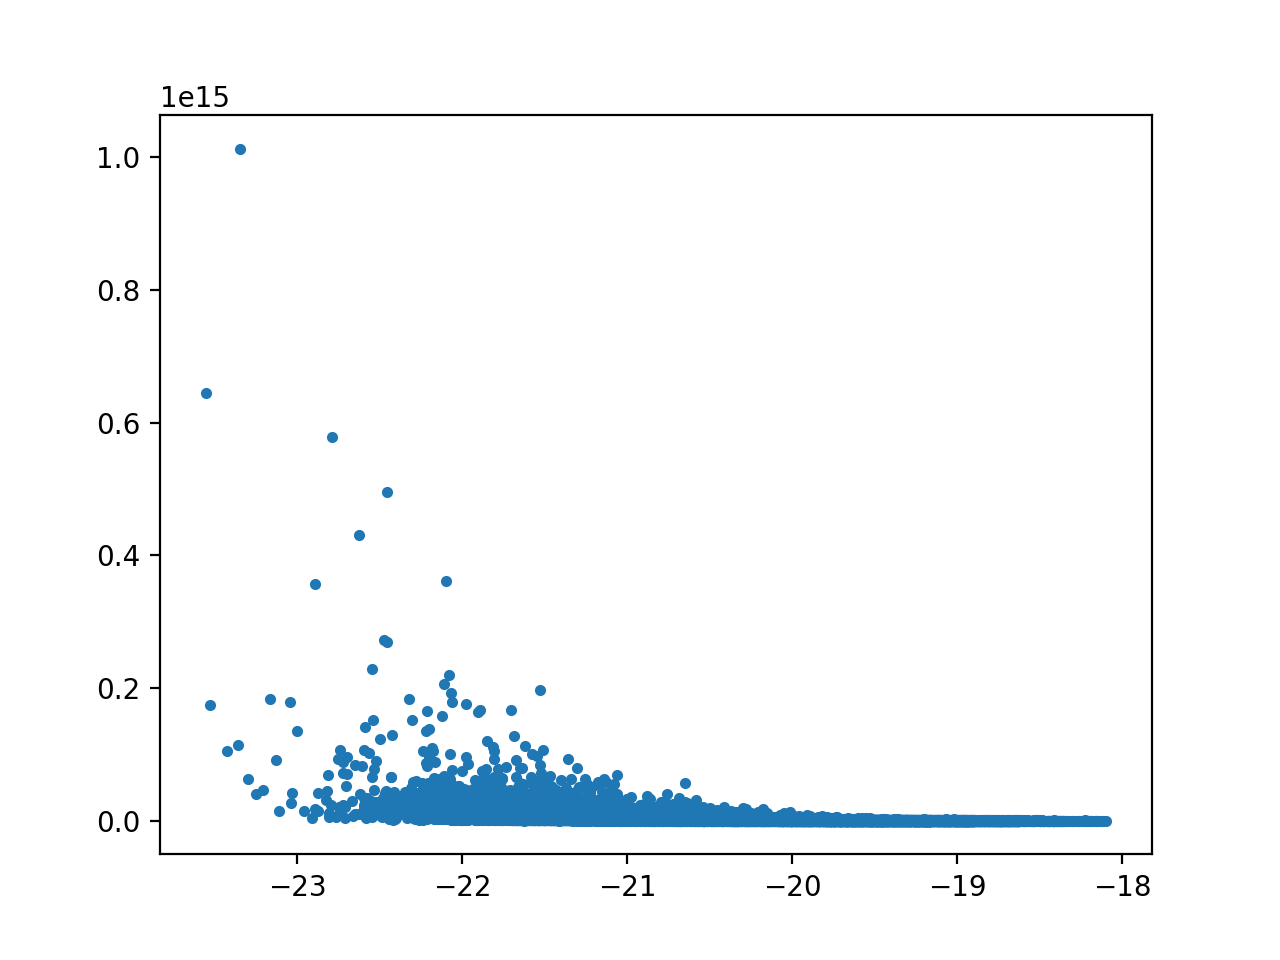

<IPython.core.display.Javascript object>


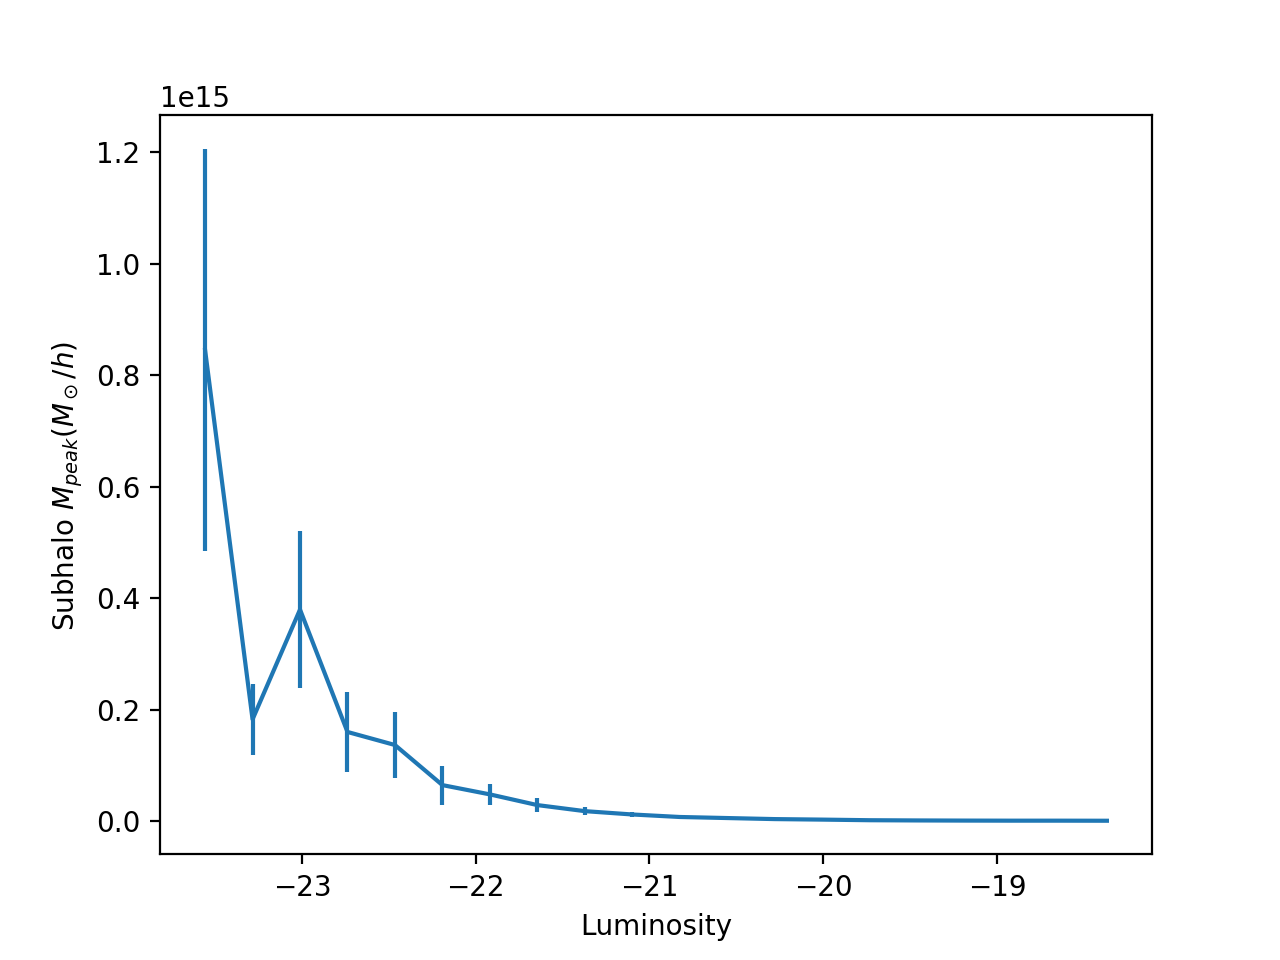

<IPython.core.display.Javascript object>


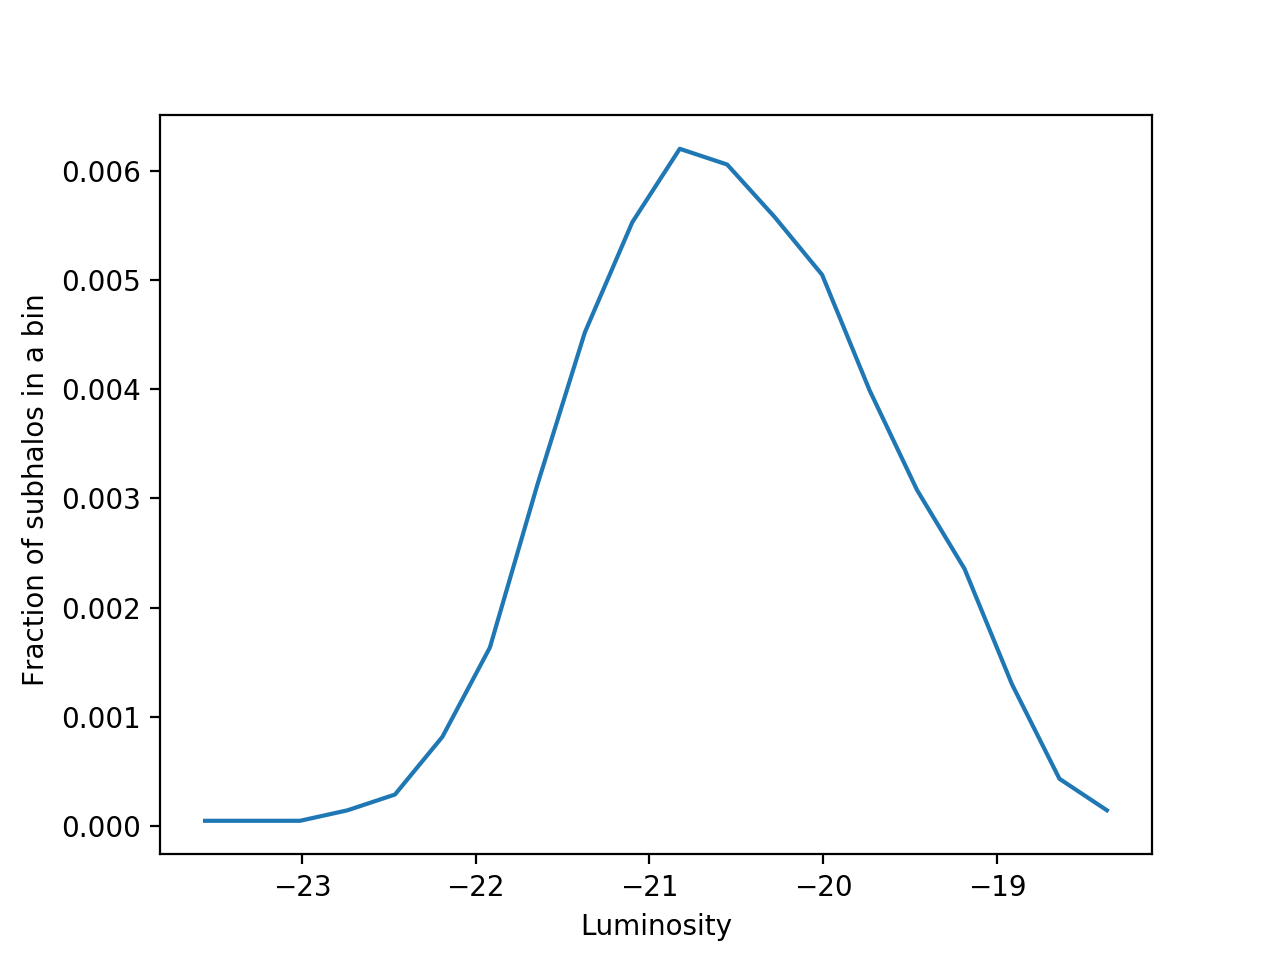

In [46]:
%matplotlib notebook 
# ========== GET THE LUMINOSITIES ==========

# sort based on the index 
# lums = np.asarray(full_catalog[downsampled_idxs_array])


# ====== GET THE MPEAKS FOR ALL OF THE SUBHALOS ======

# get the subhalos (pId != -1)
pId_cut = np.where(halocat.halo_table["halo_upid"] != -1)[0]

# find the cut between these two arrays 
mask_total = np.intersect1d(downsampled_idxs_array, pId_cut)

mpeak_sbh = halocat.halo_table["halo_Mpeak"][mask_total]

lums_cut = full_catalog[mask_total]

# ======== BIN BY LUMINOSITY ===========
plt.figure()
n, lumbins, patches = plt.hist(lums_cut, bins = 20)
plt.xlabel("Luminosity")
plt.savefig("/Users/eniaxhakaj/Desktop/lum_hist.jpg")

mpeak_95s = []
fracs = []
errors = []
plt.figure()
plt.scatter(lums_cut, mpeak_sbh, marker = ".")

for ibin, bins in enumerate(lumbins):
    
    if ibin == len(lumbins)-1: 
        break
    # get the index bins 
    idx_bin = np.where((lums_cut>bins) & (lums_cut<lumbins[ibin+1]))[0]
    
    # get the subhalos 
    mpeak_subsamp = mpeak_sbh[idx_bin]
    
    # get the 95th percentile 
    mpeak_95 = np.percentile(mpeak_subsamp, 95)
    
    frac = len(np.where(mpeak_95<mpeak_subsamp)[0])/len(mpeak_sbh)
    
    mpeak_95s.append(mpeak_95)
    fracs.append(frac)
    errors.append(np.std(mpeak_subsamp))
    
    
#     plt.figure()
#     plt.hist(mpeak_subsamp, bins = 10)
#     plt.axvline(mpeak_95, "k")
    
plt.figure()
plt.errorbar(lumbins[:-1], mpeak_95s, yerr = errors)
plt.xlabel("Luminosity")
plt.ylabel(r"Subhalo $M_{peak} (M_\odot/h)$ ")
plt.savefig("/Users/eniaxhakaj/Desktop/lum_subhalo_plot.jpg")
plt.figure()
plt.plot(lumbins[:-1], fracs)
plt.xlabel("Luminosity")
plt.ylabel(r"Fraction of subhalos in a bin ")
plt.savefig("/Users/eniaxhakaj/Desktop/lum_frac_plot.jpg")

In [41]:
frac

array([0.00076886, 0.00144161, 0.00216242])

In [ ]:
downsampled_idxs_cut.shape

In [ ]:
b3 = [val for val in lum_sorted if val in downsampled_idxs_cut]

In [ ]:
np.isnan(lum_sorted)